# Численное моделирование распространения сейсмических волн в двумерной среде MILEN SEM 2D

## Часть I: Интерполяция упругих параметров материалов

### Управление отображением графиков

**Флаг SHOW_PLOTS:**
- `True` — показывать графики в блокноте + сохранять в файлы
- `False` — только сохранять в файлы (рекомендуется для работы с нейросетями)


### Задача

Интерполяция упругих параметров (Vp, Vs, плотность) между двумя скважинами для создания 2D модели. Сравнение линейной интерполяции и послойного кригинга.

In [1]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt

from pykrige.ok import OrdinaryKriging
import warnings

In [2]:

# Глобальный флаг для управления отображением графиков
SHOW_PLOTS = True  # True - показывать графики, False - только сохранять

### 1. Параметры численной модели

**Параметры сетки:**
- Размер: 1175×244 ячейки (10×10 м каждая)
- Протяженность: 11750×2440 м
- Расстояние между скважинами: 3250 м
- Скважины на позициях: 4250 м и 7500 м от начала профиля

**Упругие параметры:**
- **Vp** — скорость P-волн (м/с)
- **Vs** — скорость S-волн (м/с)  
- **ρ** — плотность (г/см³)


### 2. Исходные данные скважинных измерений

**Исходные данные:**
- `src/well1_Backus_Elast_Vp_Vs_rhob.txt` — скважина 1
- `src/well_2_Backus_Elast_param_Vp_Vs_rhob.txt` — скважина 2

**Обработка:**
- Коррекция глубин до целых десятков метров
- Обрезка до 244 уровней (шаг 10 м)
- Конвертация в массивы NumPy

In [3]:
# Парсинг данных скважин
def parse_well_data(filepath):
    """
    Парсит файл с данными скважины и возвращает исправленные данные
    Используем ручной парсинг, так как pandas пропускает одну строку.
    """
    # Ручной парсинг файла для получения всех строк
    with open(filepath, 'r') as f:
        lines = f.readlines()[1:]  # пропускаем заголовок
    
    data = []
    for line in lines:
        parts = line.split()
        if len(parts) >= 4:  # проверяем, что есть все 4 значения
            data.append([float(parts[1]), float(parts[2]), float(parts[3])])  # Vp, rhob, Vs
    
    data_array = np.array(data)
    num_points = len(data_array)
    
    # Создаем правильные глубины - шаг 10 м начиная с 10 м для всех точек
    corrected_depths = np.arange(10, 10 + num_points * 10, 10)
    
    # Извлекаем параметры
    vp = data_array[:, 0]    # Vp - скорость продольной волны
    rhob = data_array[:, 1]  # Плотность
    vs = data_array[:, 2]    # Vs - скорость поперечной волны
    
    return corrected_depths, vp, rhob, vs

# Парсим данные первой скважины
well1_depth, well1_vp, well1_rhob, well1_vs = parse_well_data('src/well1_Backus_Elast_Vp_Vs_rhob.txt')

# Парсим данные второй скважины
well2_depth, well2_vp, well2_rhob, well2_vs = parse_well_data('src/well_2_Backus_Elast_param_Vp_Vs_rhob.txt')

# Обрезаем данные обеих скважин до 244 ячеек (как требуется для модели)
well1_depth = well1_depth[:244]
well1_vp = well1_vp[:244]
well1_rhob = well1_rhob[:244]
well1_vs = well1_vs[:244]

well2_depth = well2_depth[:244]
well2_vp = well2_vp[:244]
well2_rhob = well2_rhob[:244]
well2_vs = well2_vs[:244]

print("Данные первой скважины:")
print(f"Количество точек: {len(well1_depth)}")
print(f"Глубины: от {well1_depth[0]} до {well1_depth[-1]} м")
print(f"Vp: от {well1_vp.min():.2f} до {well1_vp.max():.2f} м/с")
print(f"Vs: от {well1_vs.min():.2f} до {well1_vs.max():.2f} м/с")
print(f"Плотность: от {well1_rhob.min():.3f} до {well1_rhob.max():.3f} г/см³")

print("\nДанные второй скважины:")
print(f"Количество точек: {len(well2_depth)}")
print(f"Глубины: от {well2_depth[0]} до {well2_depth[-1]} м")
print(f"Vp: от {well2_vp.min():.2f} до {well2_vp.max():.2f} м/с")
print(f"Vs: от {well2_vs.min():.2f} до {well2_vs.max():.2f} м/с")
print(f"Плотность: от {well2_rhob.min():.3f} до {well2_rhob.max():.3f} г/см³")


Данные первой скважины:
Количество точек: 244
Глубины: от 10 до 2440 м
Vp: от 1213.92 до 3997.27 м/с
Vs: от 666.80 до 2197.64 м/с
Плотность: от 1.815 до 2.375 г/см³

Данные второй скважины:
Количество точек: 244
Глубины: от 10 до 2440 м
Vp: от 1428.60 до 4279.73 м/с
Vs: от 784.87 до 2353.00 м/с
Плотность: от 1.864 до 2.421 г/см³


### 3. Методы интерполяции

1. **Линейная интерполяция** — горизонтальная интерполяция между скважинами
2. **Послойный кригинг** — кригинг внутри 18 геологических слоев 

#### 3.1. Метод линейной интерполяции

**Алгоритм:**
- Скважины в позициях 425 и 750 (индексы сетки)
- Линейная интерполяция между скважинами для каждой глубины
- Константная экстраполяция за пределами скважин
- Результат: массив [1175×244×3]

Размер массива модели: (1175, 244, 3)
Диапазон Vp: 1213.92 - 4279.73 м/с
Диапазон плотности: 1.815 - 2.421 г/см³
Диапазон Vs: 666.80 - 2353.00 м/с
Результаты линейной интерполяции сохранены в файл 'linear_interpolation.png'


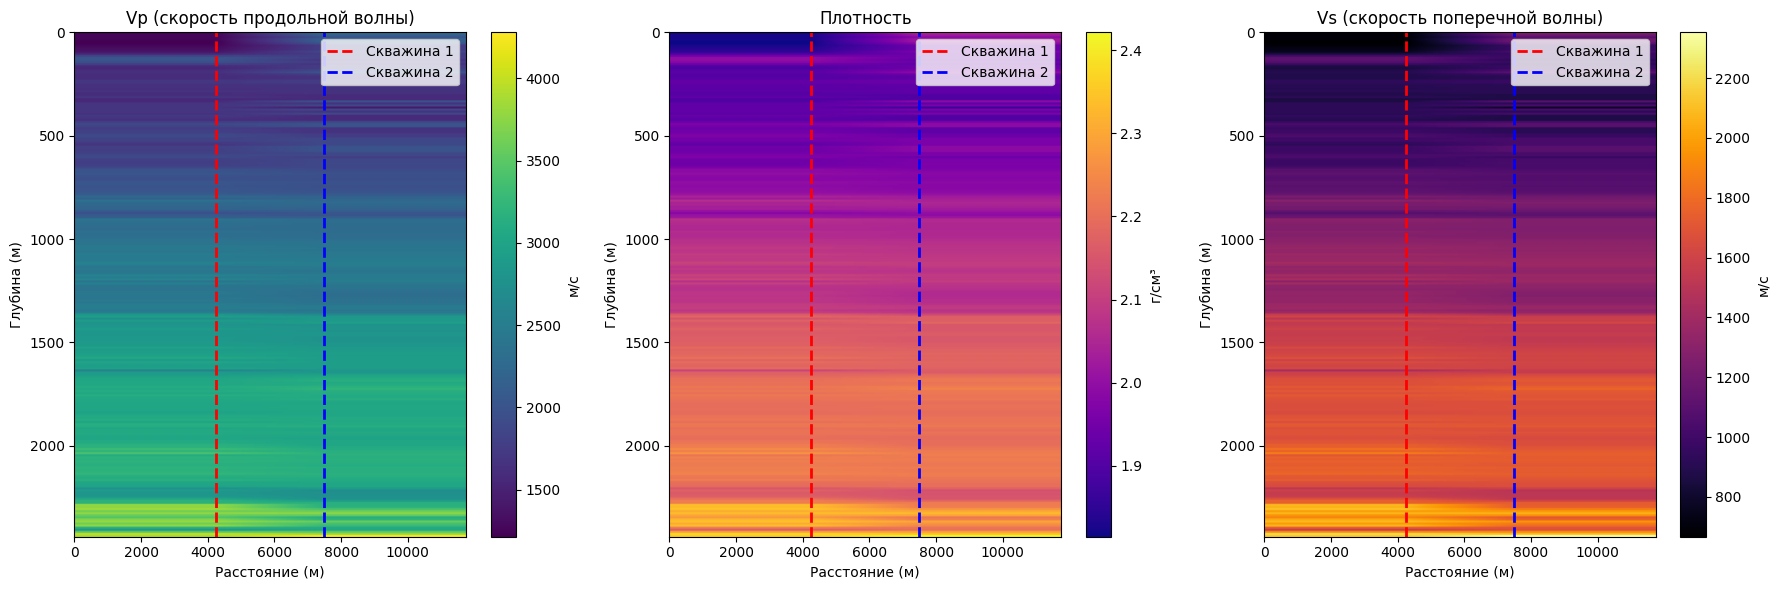

In [4]:
# Создаем массив для хранения упругих параметров модели
# Размерность: [горизонталь x вертикаль x параметры]
# Параметры: 0 - Vp, 1 - плотность, 2 - Vs
linear_params = np.zeros((1175, 244, 3))

# Индексы скважин в массиве модели
well1_idx = 425  # первая скважина
well2_idx = 750  # вторая скважина

# Помещаем данные первой скважины в модель
linear_params[well1_idx, :, 0] = well1_vp      # Vp
linear_params[well1_idx, :, 1] = well1_rhob    # Плотность  
linear_params[well1_idx, :, 2] = well1_vs      # Vs

# Помещаем данные второй скважины в модель
linear_params[well2_idx, :, 0] = well2_vp      # Vp
linear_params[well2_idx, :, 1] = well2_rhob    # Плотность
linear_params[well2_idx, :, 2] = well2_vs      # Vs

# Линейная интерполяция между скважинами для каждого слоя
for depth_idx in range(244):
    # Интерполяция Vp
    linear_params[:well1_idx, depth_idx, 0] = well1_vp[depth_idx]
    linear_params[well1_idx:well2_idx, depth_idx, 0] = np.linspace(
        well1_vp[depth_idx], well2_vp[depth_idx], well2_idx - well1_idx
    )
    linear_params[well2_idx:, depth_idx, 0] = well2_vp[depth_idx]
    
    # Интерполяция плотности
    linear_params[:well1_idx, depth_idx, 1] = well1_rhob[depth_idx]
    linear_params[well1_idx:well2_idx, depth_idx, 1] = np.linspace(
        well1_rhob[depth_idx], well2_rhob[depth_idx], well2_idx - well1_idx
    )
    linear_params[well2_idx:, depth_idx, 1] = well2_rhob[depth_idx]
    
    # Интерполяция Vs
    linear_params[:well1_idx, depth_idx, 2] = well1_vs[depth_idx]
    linear_params[well1_idx:well2_idx, depth_idx, 2] = np.linspace(
        well1_vs[depth_idx], well2_vs[depth_idx], well2_idx - well1_idx
    )
    linear_params[well2_idx:, depth_idx, 2] = well2_vs[depth_idx]

# Проверяем размеры массива
print(f"Размер массива модели: {linear_params.shape}")
print(f"Диапазон Vp: {linear_params[:, :, 0].min():.2f} - {linear_params[:, :, 0].max():.2f} м/с")
print(f"Диапазон плотности: {linear_params[:, :, 1].min():.3f} - {linear_params[:, :, 1].max():.3f} г/см³")
print(f"Диапазон Vs: {linear_params[:, :, 2].min():.2f} - {linear_params[:, :, 2].max():.2f} м/с")

# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Vp (скорость продольной волны)
im0 = axes[0].imshow(linear_params[:, :, 0].T, aspect='auto', origin='upper', 
                     cmap='viridis', extent=[0, 11750, 2440, 0])
axes[0].set_title('Vp (скорость продольной волны)')
axes[0].set_xlabel('Расстояние (м)')
axes[0].set_ylabel('Глубина (м)')
plt.colorbar(im0, ax=axes[0], label='м/с')

# Плотность
im1 = axes[1].imshow(linear_params[:, :, 1].T, aspect='auto', origin='upper',
                     cmap='plasma', extent=[0, 11750, 2440, 0])
axes[1].set_title('Плотность')
axes[1].set_xlabel('Расстояние (м)')
axes[1].set_ylabel('Глубина (м)')
plt.colorbar(im1, ax=axes[1], label='г/см³')

# Vs (скорость поперечной волны)
im2 = axes[2].imshow(linear_params[:, :, 2].T, aspect='auto', origin='upper',
                     cmap='inferno', extent=[0, 11750, 2440, 0])
axes[2].set_title('Vs (скорость поперечной волны)')
axes[2].set_xlabel('Расстояние (м)')
axes[2].set_ylabel('Глубина (м)')
plt.colorbar(im2, ax=axes[2], label='м/с')

# Добавляем линии скважин
for ax in axes:
    ax.axvline(x=4250, color='red', linestyle='--', linewidth=2, label='Скважина 1')
    ax.axvline(x=7500, color='blue', linestyle='--', linewidth=2, label='Скважина 2')
    ax.legend()

# plt.tight_layout()
# plt.show()
plt.tight_layout()
plt.savefig('linear_interpolation.png', dpi=300, bbox_inches='tight')  
print("Результаты линейной интерполяции сохранены в файл 'linear_interpolation.png'")
if SHOW_PLOTS:
    plt.show()
else:
    plt.close()



#### 3.2. Метод послойного кригинга

Кригинг внутри каждого из 18 геологических слоев.

**Параметры:**
- Слои: 18
- Границы: 0, 17, 30, 48, 90, 112, 121, 137, 165, 220, 222, 224, 226, 228, 230, 232, 240, 242, 244
- Метод: обыкновенный кригинг, линейная вариограмма


In [5]:
# Импорт библиотек для кригинга

warnings.filterwarnings('ignore', category=RuntimeWarning)

# Фиксируем случайный генератор для воспроизводимости
np.random.seed(42)

print("Инициализация параметров послойного кригинга...")

# Определяем границы слоев
layer_boundaries = [0, 17, 30, 48, 90, 112, 121, 137, 165, 220, 222, 224, 226, 228, 230, 232, 240, 242, 244]
n_layers = len(layer_boundaries) - 1

print(f"Количество слоев: {n_layers}")

# Создаем массив для результатов кригинга
kriging_params = np.zeros((1175, 244, 3))

# Координаты скважин (в метрах)
well1_x = 4250  # позиция первой скважины
well2_x = 7500  # позиция второй скважины

# Массив всех горизонтальных позиций для интерполяции
x_positions = np.linspace(0, 11750, 1175)

# Индексы скважин в массиве
well1_idx = 425
well2_idx = 750

print("Начало процедуры послойного кригинга...")
print(f"   Скважина 1: позиция {well1_x}м (индекс {well1_idx})")
print(f"   Скважина 2: позиция {well2_x}м (индекс {well2_idx})")
print(f"   Всего позиций для интерполяции: {len(x_positions)}")
print()

# Обрабатываем каждый слой
for layer_i in range(n_layers):
    start_depth = layer_boundaries[layer_i]
    end_depth = layer_boundaries[layer_i + 1]
    layer_thickness = end_depth - start_depth
    
    print(f"Обработка слоя {layer_i+1}/{n_layers}: глубина {start_depth}-{end_depth} ({layer_thickness} ячеек)")
    
    # Для каждого параметра в слое
    for param_idx, param_name in enumerate(['Vp', 'Плотность', 'Vs']):
        
        # Извлекаем данные скважин для текущего слоя
        if param_idx == 0:  # Vp
            well1_values = well1_vp[start_depth:end_depth]
            well2_values = well2_vp[start_depth:end_depth]
        elif param_idx == 1:  # Плотность
            well1_values = well1_rhob[start_depth:end_depth]
            well2_values = well2_rhob[start_depth:end_depth]
        else:  # Vs
            well1_values = well1_vs[start_depth:end_depth]
            well2_values = well2_vs[start_depth:end_depth]
        
        # Для каждой глубины в слое применяем кригинг
        for depth_in_layer in range(layer_thickness):
            actual_depth_idx = start_depth + depth_in_layer
            
            # Координаты и значения известных точек (скважины)
            known_x = np.array([well1_x, well2_x])
            known_values = np.array([well1_values[depth_in_layer], well2_values[depth_in_layer]])
            
            # Проверяем, есть ли различия в данных
            if np.std(known_values) < 1e-10:
                # Если значения одинаковы, просто заполняем константой
                kriging_params[:, actual_depth_idx, param_idx] = known_values[0]
            else:
                try:
                    # Добавляем небольшой шум к координатам для стабильности кригинга
                    known_x_noise = known_x + np.random.normal(0, 1, len(known_x))  # 1м шум
                    
                    # Создаем объект кригинга с фиксированными параметрами
                    OK = OrdinaryKriging(
                        known_x_noise, np.zeros_like(known_x_noise), known_values,
                        variogram_model='linear',
                        variogram_parameters={'slope': 1.0, 'nugget': 0.1},  # Фиксированные параметры
                        verbose=False,
                        enable_plotting=False,
                        exact_values=False  # Разрешаем небольшие отклонения
                    )
                    
                    # Выполняем интерполяцию для всех горизонтальных позиций
                    z_pred, ss = OK.execute('points', x_positions, np.zeros_like(x_positions))
                    
                    # Сохраняем результаты
                    kriging_params[:, actual_depth_idx, param_idx] = z_pred
                    
                except Exception as e:
                    # В случае ошибки используем линейную интерполяцию как fallback
                    interpolated = np.interp(x_positions, known_x, known_values)
                    kriging_params[:, actual_depth_idx, param_idx] = interpolated
    
    # Прогресс
    progress = ((layer_i + 1) / n_layers) * 100
    print(f"   Завершен ({progress:.1f}% общего прогресса)")

print()
print("Процедура кригинга завершена.")
print(f"Размер массива результатов: {kriging_params.shape}")
print(f"   Диапазон Vp: {kriging_params[:, :, 0].min():.2f} - {kriging_params[:, :, 0].max():.2f} м/с")
print(f"   Диапазон плотности: {kriging_params[:, :, 1].min():.3f} - {kriging_params[:, :, 1].max():.3f} г/см³")
print(f"   Диапазон Vs: {kriging_params[:, :, 2].min():.2f} - {kriging_params[:, :, 2].max():.2f} м/с")


Инициализация параметров послойного кригинга...
Количество слоев: 18
Начало процедуры послойного кригинга...
   Скважина 1: позиция 4250м (индекс 425)
   Скважина 2: позиция 7500м (индекс 750)
   Всего позиций для интерполяции: 1175

Обработка слоя 1/18: глубина 0-17 (17 ячеек)
   Завершен (5.6% общего прогресса)
Обработка слоя 2/18: глубина 17-30 (13 ячеек)
   Завершен (11.1% общего прогресса)
Обработка слоя 3/18: глубина 30-48 (18 ячеек)
   Завершен (16.7% общего прогресса)
Обработка слоя 4/18: глубина 48-90 (42 ячеек)
   Завершен (22.2% общего прогресса)
Обработка слоя 5/18: глубина 90-112 (22 ячеек)
   Завершен (27.8% общего прогресса)
Обработка слоя 6/18: глубина 112-121 (9 ячеек)
   Завершен (33.3% общего прогресса)
Обработка слоя 7/18: глубина 121-137 (16 ячеек)
   Завершен (38.9% общего прогресса)
Обработка слоя 8/18: глубина 137-165 (28 ячеек)
   Завершен (44.4% общего прогресса)
Обработка слоя 9/18: глубина 165-220 (55 ячеек)
   Завершен (50.0% общего прогресса)
Обработка сло

Создание визуализации результатов кригинга...
Результаты кригинга сохранены в файл 'kriging_interpolation.png'


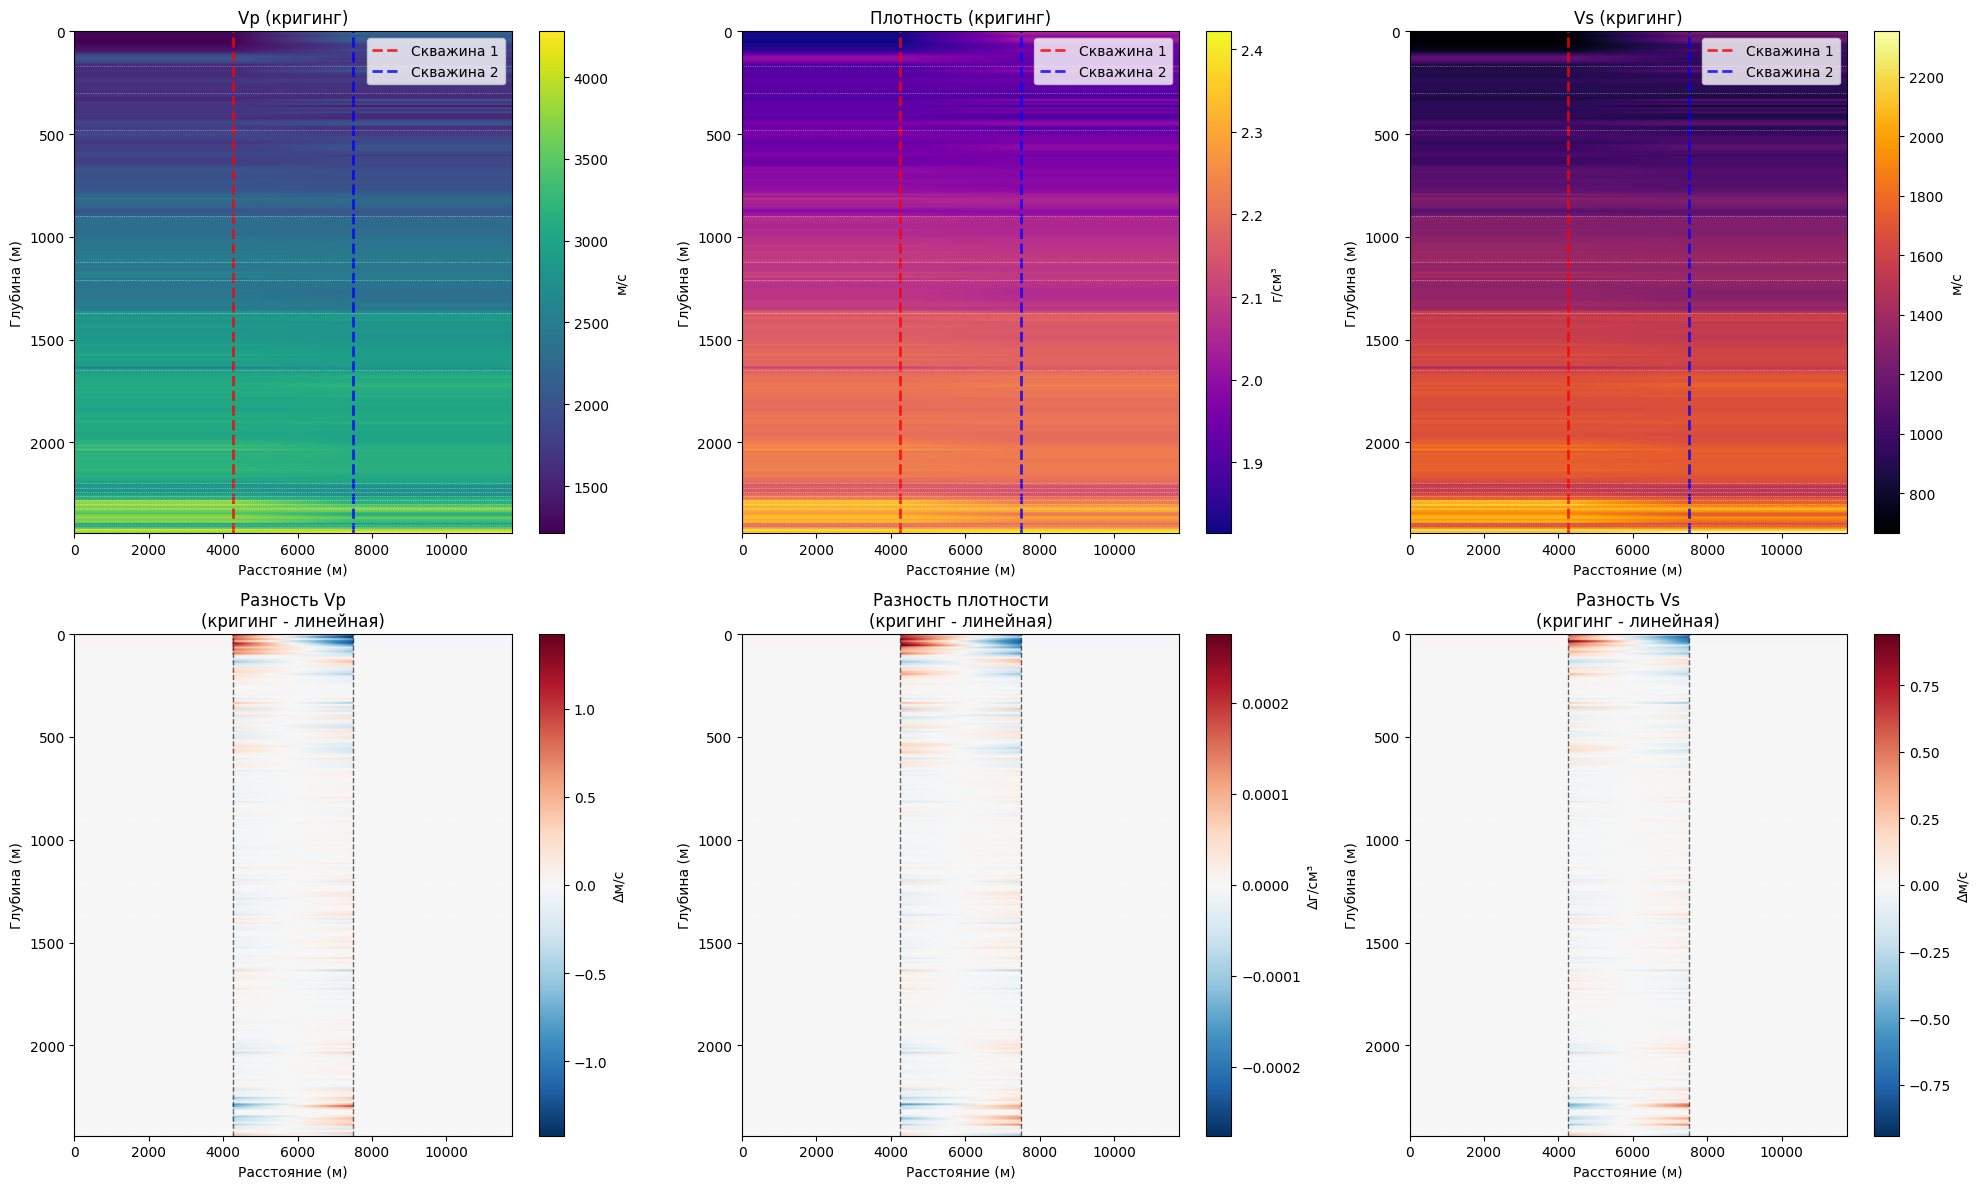


СТАТИСТИКА СРАВНЕНИЯ МЕТОДОВ:
Vp:
  Средняя разность: -0.000 м/с
  СКО разности: 0.073 м/с
  Макс. разность: 1.183 м/с
  Мин. разность: -1.423 м/с
Плотность:
  Средняя разность: 0.000 г/см³
  СКО разности: 0.000 г/см³
  Макс. разность: 0.000 г/см³
  Мин. разность: -0.000 г/см³
Vs:
  Средняя разность: 0.000 м/с
  СКО разности: 0.042 м/с
  Макс. разность: 0.941 м/с
  Мин. разность: -0.785 м/с

Результаты кригинга сохранены в файл 'model1_material.npz'
Размер файла: ~6.6 МБ

ИНФОРМАЦИЯ О ВЫЧИСЛИТЕЛЬНОЙ СЛОЖНОСТИ:
   Послойный кригинг: 18 слоев × 244 глубин × 3 параметра = 13,176 операций кригинга
   Линейная интерполяция: 244 глубины × 3 параметра = 732 операций интерполяции
   Соотношение сложности: 18.0x


In [6]:
# Визуализация результатов кригинга
print("Создание визуализации результатов кригинга...")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Верхний ряд - результаты кригинга
param_names = ['Vp (кригинг)', 'Плотность (кригинг)', 'Vs (кригинг)']
cmaps = ['viridis', 'plasma', 'inferno']
units = ['м/с', 'г/см³', 'м/с']

for i in range(3):
    im = axes[0, i].imshow(kriging_params[:, :, i].T, aspect='auto', origin='upper',
                          cmap=cmaps[i], extent=[0, 11750, 2440, 0])
    axes[0, i].set_title(param_names[i])
    axes[0, i].set_xlabel('Расстояние (м)')
    axes[0, i].set_ylabel('Глубина (м)')
    plt.colorbar(im, ax=axes[0, i], label=units[i])
    
    # Добавляем линии скважин
    axes[0, i].axvline(x=4250, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Скважина 1')
    axes[0, i].axvline(x=7500, color='blue', linestyle='--', linewidth=2, alpha=0.8, label='Скважина 2')
    
    # Добавляем границы слоев
    for boundary in layer_boundaries[1:-1]:  # исключаем первый и последний
        depth_m = boundary * 10  # переводим в метры
        axes[0, i].axhline(y=depth_m, color='white', linestyle=':', linewidth=0.5, alpha=0.7)
    
    axes[0, i].legend(loc='upper right')

# Нижний ряд - сравнение с линейной интерполяцией
comparison_titles = ['Разность Vp\n(кригинг - линейная)', 'Разность плотности\n(кригинг - линейная)', 'Разность Vs\n(кригинг - линейная)']

for i in range(3):
    diff = kriging_params[:, :, i] - linear_params[:, :, i]
    
    # Используем симметричную цветовую схему для различий
    vmax = np.abs(diff).max()
    im = axes[1, i].imshow(diff.T, aspect='auto', origin='upper',
                          cmap='RdBu_r', vmin=-vmax, vmax=vmax,
                          extent=[0, 11750, 2440, 0])
    axes[1, i].set_title(comparison_titles[i])
    axes[1, i].set_xlabel('Расстояние (м)')
    axes[1, i].set_ylabel('Глубина (м)')
    plt.colorbar(im, ax=axes[1, i], label=f'Δ{units[i]}')
    
    # Добавляем линии скважин
    axes[1, i].axvline(x=4250, color='black', linestyle='--', linewidth=1, alpha=0.6)
    axes[1, i].axvline(x=7500, color='black', linestyle='--', linewidth=1, alpha=0.6)
    
    # Добавляем границы слоев
    for boundary in layer_boundaries[1:-1]:
        depth_m = boundary * 10
        axes[1, i].axhline(y=depth_m, color='white', linestyle=':', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig('kriging_interpolation.png', dpi=300, bbox_inches='tight')
print("Результаты кригинга сохранены в файл 'kriging_interpolation.png'")
if SHOW_PLOTS:
    plt.show()
else:
    plt.close()
# Статистика различий
print("\nСТАТИСТИКА СРАВНЕНИЯ МЕТОДОВ:")
print("=" * 50)
param_names_short = ['Vp', 'Плотность', 'Vs']
for i, param in enumerate(param_names_short):
    diff = kriging_params[:, :, i] - linear_params[:, :, i]
    print(f"{param}:")
    print(f"  Средняя разность: {diff.mean():.3f} {units[i]}")
    print(f"  СКО разности: {diff.std():.3f} {units[i]}")
    print(f"  Макс. разность: {diff.max():.3f} {units[i]}")
    print(f"  Мин. разность: {diff.min():.3f} {units[i]}")

# Сохраняем результаты кригинга
np.savez('model1_material.npz',
         kriging_params=kriging_params,
         linear_params=linear_params,
         layer_boundaries=layer_boundaries,
         well1_idx=well1_idx,
         well2_idx=well2_idx,
         method='ordinary_kriging_layered')

print(f"\nРезультаты кригинга сохранены в файл 'model1_material.npz'")
print(f"Размер файла: ~{kriging_params.nbytes / (1024*1024):.1f} МБ")

# Краткое сравнение вычислительной эффективности
print(f"\nИНФОРМАЦИЯ О ВЫЧИСЛИТЕЛЬНОЙ СЛОЖНОСТИ:")
print(f"   Послойный кригинг: {n_layers} слоев × 244 глубин × 3 параметра = {n_layers*244*3:,} операций кригинга")
print(f"   Линейная интерполяция: 244 глубины × 3 параметра = {244*3:,} операций интерполяции")
print(f"   Соотношение сложности: {(n_layers*244*3)/(244*3):.1f}x")


### 4. Выходные данные

Результаты сохраняются в `model1_material.npz` (6.6 МБ).

**Содержимое:**

**1. `kriging_params`** — массив [1175×244×3], кригинг
**2. `linear_params`** — массив [1175×244×3], линейная интерполяция

**3. `layer_boundaries`** — границы 18 слоев
**4. `well1_idx`, `well2_idx`** — позиции скважин (425, 750)
**5. `method`** — "ordinary_kriging_layered"

**Использование:**
```python
import numpy as np

# Загрузка данных
data = np.load('model1_material.npz')

# Извлечение результатов кригинга
vp_kriging = data['kriging_params'][:, :, 0]      # Vp
density_kriging = data['kriging_params'][:, :, 1]  # плотность  
vs_kriging = data['kriging_params'][:, :, 2]      # Vs

# Извлечение границ слоев
layers = data['layer_boundaries']

# Позиции скважин
well1_pos = data['well1_idx']  # 425
well2_pos = data['well2_idx']  # 750
```
